In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras_unet_collection import models
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tqdm import tqdm

'''
Imports all neccesary libraries
'''

'\nImports all neccesary libraries\n'

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

'''
Sanity check for gpu detection
'''


TensorFlow version: 2.10.0
Built with CUDA: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'\nSanity check for gpu detection\n'

In [ ]:
dim = 256
IMG_HEIGHT = dim
IMG_WIDTH = dim
IMG_CHANNELS = 3
BATCH_SIZE = 4
FILTERS = [64, 128, 256, 512, 1024]

EPOCHS = 100
PATIENCE = 20
LEARNING_RATE = 1e-4

image_dir = "ISIC2018_Task1-2_Training_Input"
mask_dir = "ISIC2018_Task1_Training_GroundTruth"

'''
Define global variables for desired image dimensions and the data directories

128x128 batch = 32 filters = [64, 128, 256, 512]
192x192 batch = 12 filters = [64, 128, 256, 512, 1024]
256x256 batch = 4 filters, 4 accumulation steps = [64, 128, 256, 512, 1024]
'''

'\nDefine global variables for desired image dimensions and the data directories\n\n128x128 batch = 32 filters = [64, 128, 256, 512] \n192x192 batch = 12 filters = [64, 128, 256, 512, 1024]\n256x256 batch = 4 filters, 4 accumulation steps = [64, 128, 256, 512, 1024]\n'

In [ ]:
image_filenames = sorted(os.listdir(image_dir))
mask_filenames = sorted(os.listdir(mask_dir))

'''
lists all files in data directories sorted so that the image and mask pair are aligned
'''

'\nlists all files in data directories sorted so that the image and mask pair are aligned\n'

In [ ]:
def load_image_mask_pair(image_path, mask_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method="nearest")
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method="nearest")
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask


'''
defines a function for processing image and mask pairs
reads image, decodes from bytes to tensor, resizes to desired dimensions, normalizes pixel values
same process applied to mask but only one channel for binary mask
'''

'\ndefines a function for processing image and mask pairs\nreads image, decodes from bytes to tensor, resizes to desired dimensions, normalizes pixel values\nsame process applied to mask but only one channel for binary mask\n'

In [ ]:
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]
mask_paths = [os.path.join(mask_dir, fname) for fname in mask_filenames]

images = []
masks = []

for img_path, msk_path in tqdm(zip(image_paths, mask_paths), desc="Loading image-mask pairs", total=len(image_paths)):

    img, msk = load_image_mask_pair(img_path, msk_path)

    images.append(img)
    masks.append(msk)

images = tf.stack(images)
masks = tf.stack(masks)

'''
creates a list of all file paths in the image and mask directories
loops over each pair (previously sorted to line up for zip) and calls the load image function
append the images to their respective lists and then stacks them into a single tensor for batching
'''

Loading image-mask pairs: 100%|██████████| 2594/2594 [06:36<00:00,  6.55it/s]


'\ncreates a list of all file paths in the image and mask directories\nloops over each pair (previously sorted to line up for zip) and calls the load image function\nappend the images to their respective lists and then stacks them into a single tensor for batching\n'

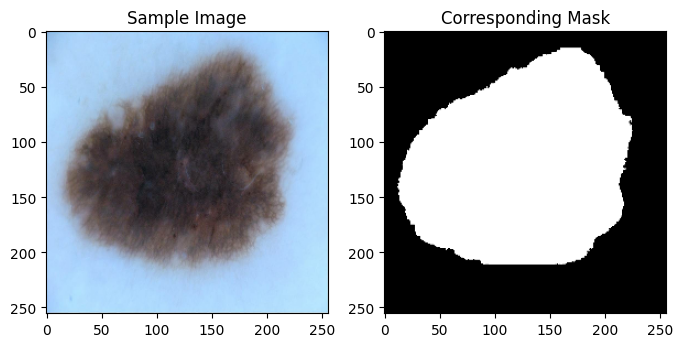

'\nsanity check to make sure images and masks were properly aligned\nmust use squeeze so that mask can be in black and white\n'

In [ ]:
def sanity_check_sample(i):

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    plt.title("Sample Image")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(masks[i]), cmap='gray')
    plt.title("Corresponding Mask")

    plt.show()

sanity_check_sample(0)

'''
sanity check to make sure images and masks were properly aligned
must use squeeze so that mask can be in black and white
'''

In [ ]:
val_ratio = 0.2
dataset_size = len(images)
val_size = int(val_ratio * dataset_size)

dataset = tf.data.Dataset.from_tensor_slices((images, masks))

dataset = dataset.shuffle(buffer_size=dataset_size, seed=42, reshuffle_each_iteration=False)

val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


'''
defines the amount of data to be used for validation
slices the tensors into a dataset and shuffles it
take and skip data so that there is no overlap between training and validation
batch the dataset and prefetch it
'''

'\ndefines the amount of data to be used for validation\nslices the tensors into a dataset and shuffles it\ntake and skip data so that there is no overlap between training and validation\nbatch the dataset and prefetch it\n'

In [ ]:
def jaccard_index(y_true, y_pred, smooth=1e-6):

    y_pred = tf.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection

    return (intersection + smooth) / (union + smooth)

def dice_score(y_true, y_pred, smooth=1e-6):

    y_pred = tf.round(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)

    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

'''
defines jaccard index and dice score functions for evaluating
jaccard is intersection over union measuring how much predicted masks overlap with ground truth masks
dice score also measures how much the prediced mask overlaps with the true mask
'''

'\ndefines jaccard index and dice score functions for evaluating\njaccard is intersection over union measuring how much predicted masks overlap with ground truth masks\ndice score also measures how much the prediced mask overlaps with the true mask\n'

In [ ]:

unet_model = models.unet_2d(
    input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    filter_num=FILTERS,
    n_labels=1,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    output_activation='Sigmoid',
    batch_norm=True,
    pool=True,
    unpool=True
)
'''
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_score, jaccard_index]
)

history = unet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)
'''

'''
DEFAULT FITTING FOR NO GRADIENT ACCUMULATION

initializes the u-net model with desired filters
sigmoid activation function used for binary output

Watch validation loss
Stop if no improvement after 10 epochs
Go back to the best model
Print when early stopping kicks in
128 stopped at epoch 24
192 stopped at epoch 28
256 stopped at epoch

compiles unet

begins training for unet
default fitting without gradient accumulation
'''

'\nDEFAULT FITTING FOR NO GRADIENT ACCUMULATION\n\ninitializes the u-net model with desired filters\nsigmoid activation function used for binary output\n\nWatch validation loss\nStop if no improvement after 10 epochs\nGo back to the best model\nPrint when early stopping kicks in\n128 stopped at epoch 24\n192 stopped at epoch 28\n256 stopped at epoch \n\ncompiles unet\n\nbegins training for unet\ndefault fitting without gradient accumulation\n'

In [ ]:

ACCUM_STEPS = 4
BEST_VAL_LOSS = np.inf
PATIENCE_COUNTER = 0

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def bce_dice_loss(y_true, y_pred):

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

loss_fn = bce_dice_loss
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

class CustomHistory:
    def __init__(self, history_dict):
        self.history = history_dict

history = {
    'loss': [], 'val_loss': [],
    'dice_loss': [], 'val_dice_loss': [],
    'dice_score': [], 'val_dice_score': [],
    'jaccard_index': [], 'val_jaccard_index': []
}

checkpoint_path = "best_model_256.h5"

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Current learning rate: {optimizer.learning_rate.numpy():.1e}")
    train_loss, train_dice_loss, train_dice, train_jaccard = [], [], [], []
    val_loss, val_dice_loss, val_dice, val_jaccard = [], [], [], []

    accum_grads = [tf.zeros_like(var) for var in unet_model.trainable_variables]
    accum_counter = 0

    for step, (x_batch, y_batch) in enumerate(tqdm(train_dataset.prefetch(tf.data.AUTOTUNE), desc="Training")):
        with tf.GradientTape() as tape:
            preds = unet_model(x_batch, training=True)
            loss = loss_fn(y_batch, preds)
            dice_only = dice_loss(y_batch, preds)

        grads = tape.gradient(loss, unet_model.trainable_variables)
        accum_grads = [a + g for a, g in zip(accum_grads, grads)]
        accum_counter += 1

        train_loss.append(loss.numpy())
        train_dice_loss.append(dice_only.numpy())
        train_dice.append(dice_score(y_batch, preds).numpy())
        train_jaccard.append(jaccard_index(y_batch, preds).numpy())

        if accum_counter == ACCUM_STEPS:
            avg_grads = [g / ACCUM_STEPS for g in accum_grads]
            optimizer.apply_gradients(zip(avg_grads, unet_model.trainable_variables))
            accum_grads = [tf.zeros_like(var) for var in unet_model.trainable_variables]
            accum_counter = 0

    for x_val, y_val in val_dataset.prefetch(tf.data.AUTOTUNE):
        val_preds = unet_model(x_val, training=False)

        v_loss = loss_fn(y_val, val_preds)
        v_dice_only = dice_loss(y_val, val_preds)

        val_loss.append(np.mean(v_loss.numpy()))
        val_dice_loss.append(float(v_dice_only))

        val_dice.append(dice_score(y_val, val_preds).numpy())
        val_jaccard.append(jaccard_index(y_val, val_preds).numpy())

    history['loss'].append(np.mean(train_loss))
    history['dice_loss'].append(np.mean(train_dice_loss))
    history['dice_score'].append(np.mean(train_dice))
    history['jaccard_index'].append(np.mean(train_jaccard))

    history['val_loss'].append(np.mean(val_loss))
    history['val_dice_loss'].append(np.mean(val_dice_loss))
    history['val_dice_score'].append(np.mean(val_dice))
    history['val_jaccard_index'].append(np.mean(val_jaccard))

    print(f"Train Loss: {history['loss'][-1]:.4f} | Dice Loss: {history['dice_loss'][-1]:.4f} | Dice: {history['dice_score'][-1]:.4f} | Jaccard: {history['jaccard_index'][-1]:.4f}")
    print(f"Val   Loss: {history['val_loss'][-1]:.4f} | Dice Loss: {history['val_dice_loss'][-1]:.4f} | Dice: {history['val_dice_score'][-1]:.4f} | Jaccard: {history['val_jaccard_index'][-1]:.4f}")

    current_val_loss = history['val_loss'][-1]
    if current_val_loss < BEST_VAL_LOSS:
        print("New best model. Saving...")
        unet_model.save(checkpoint_path)
        BEST_VAL_LOSS = current_val_loss
        PATIENCE_COUNTER = 0
    else:
        PATIENCE_COUNTER += 1
        print(f"No improvement. Patience: {PATIENCE_COUNTER}/{PATIENCE}")
        if PATIENCE_COUNTER >= PATIENCE:
            print("Early stopping triggered.")
            break

history = CustomHistory(history)



'''
custom training loop for accumulation gradient

simulate larger batch sizesby accumulating gradients over multiple small batches.
Early stopping was also applied,
saving the model checkpoint whenever validation loss improved to prevent overfitting.
'''


Epoch 1/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:19<00:00,  2.61it/s]


Train Loss: 0.7873 | Dice: 0.7150 | Jaccard: 0.5799
Val   Loss: 0.6244 | Dice: 0.7974 | Jaccard: 0.6734
New best model. Saving...

Epoch 2/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:10<00:00,  2.72it/s]


Train Loss: 0.5728 | Dice: 0.8006 | Jaccard: 0.6825
Val   Loss: 0.5659 | Dice: 0.8027 | Jaccard: 0.6845
New best model. Saving...

Epoch 3/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:05<00:00,  2.80it/s]


Train Loss: 0.4974 | Dice: 0.8296 | Jaccard: 0.7214
Val   Loss: 0.5002 | Dice: 0.8197 | Jaccard: 0.7088
New best model. Saving...

Epoch 4/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:04<00:00,  2.81it/s]


Train Loss: 0.4439 | Dice: 0.8485 | Jaccard: 0.7480
Val   Loss: 0.4406 | Dice: 0.8356 | Jaccard: 0.7290
New best model. Saving...

Epoch 5/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:09<00:00,  2.73it/s]


Train Loss: 0.4096 | Dice: 0.8581 | Jaccard: 0.7617
Val   Loss: 0.4413 | Dice: 0.8288 | Jaccard: 0.7172
No improvement. Patience: 1/20

Epoch 6/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:05<00:00,  2.79it/s]


Train Loss: 0.3769 | Dice: 0.8680 | Jaccard: 0.7762
Val   Loss: 0.4082 | Dice: 0.8417 | Jaccard: 0.7363
New best model. Saving...

Epoch 7/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:08<00:00,  2.76it/s]


Train Loss: 0.3601 | Dice: 0.8699 | Jaccard: 0.7791
Val   Loss: 0.3872 | Dice: 0.8489 | Jaccard: 0.7455
New best model. Saving...

Epoch 8/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:04<00:00,  2.81it/s]


Train Loss: 0.3400 | Dice: 0.8751 | Jaccard: 0.7867
Val   Loss: 0.4084 | Dice: 0.8351 | Jaccard: 0.7284
No improvement. Patience: 1/20

Epoch 9/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.3188 | Dice: 0.8832 | Jaccard: 0.7976
Val   Loss: 0.3965 | Dice: 0.8410 | Jaccard: 0.7373
No improvement. Patience: 2/20

Epoch 10/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.86it/s]


Train Loss: 0.3041 | Dice: 0.8866 | Jaccard: 0.8031
Val   Loss: 0.3968 | Dice: 0.8371 | Jaccard: 0.7301
No improvement. Patience: 3/20

Epoch 11/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.86it/s]


Train Loss: 0.2932 | Dice: 0.8894 | Jaccard: 0.8074
Val   Loss: 0.4036 | Dice: 0.8396 | Jaccard: 0.7337
No improvement. Patience: 4/20

Epoch 12/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.2784 | Dice: 0.8939 | Jaccard: 0.8144
Val   Loss: 0.3861 | Dice: 0.8444 | Jaccard: 0.7403
New best model. Saving...

Epoch 13/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:05<00:00,  2.80it/s]


Train Loss: 0.2754 | Dice: 0.8934 | Jaccard: 0.8131
Val   Loss: 0.3504 | Dice: 0.8527 | Jaccard: 0.7511
New best model. Saving...

Epoch 14/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:04<00:00,  2.81it/s]


Train Loss: 0.2440 | Dice: 0.9068 | Jaccard: 0.8338
Val   Loss: 0.4079 | Dice: 0.8335 | Jaccard: 0.7274
No improvement. Patience: 1/20

Epoch 15/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.2277 | Dice: 0.9126 | Jaccard: 0.8427
Val   Loss: 0.4164 | Dice: 0.8309 | Jaccard: 0.7229
No improvement. Patience: 2/20

Epoch 16/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.85it/s]


Train Loss: 0.2294 | Dice: 0.9105 | Jaccard: 0.8395
Val   Loss: 0.3906 | Dice: 0.8362 | Jaccard: 0.7300
No improvement. Patience: 3/20

Epoch 17/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.86it/s]


Train Loss: 0.2160 | Dice: 0.9156 | Jaccard: 0.8476
Val   Loss: 0.4129 | Dice: 0.8372 | Jaccard: 0.7311
No improvement. Patience: 4/20

Epoch 18/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.85it/s]


Train Loss: 0.1973 | Dice: 0.9230 | Jaccard: 0.8595
Val   Loss: 0.3642 | Dice: 0.8548 | Jaccard: 0.7576
No improvement. Patience: 5/20

Epoch 19/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.86it/s]


Train Loss: 0.2044 | Dice: 0.9183 | Jaccard: 0.8518
Val   Loss: 0.4222 | Dice: 0.8261 | Jaccard: 0.7201
No improvement. Patience: 6/20

Epoch 20/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:01<00:00,  2.85it/s]


Train Loss: 0.1982 | Dice: 0.9211 | Jaccard: 0.8562
Val   Loss: 0.3587 | Dice: 0.8509 | Jaccard: 0.7510
No improvement. Patience: 7/20

Epoch 21/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [1:18:46<00:00,  9.11s/it]     


Train Loss: 0.1931 | Dice: 0.9226 | Jaccard: 0.8586
Val   Loss: 0.3915 | Dice: 0.8450 | Jaccard: 0.7431
No improvement. Patience: 8/20

Epoch 22/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.1898 | Dice: 0.9232 | Jaccard: 0.8598
Val   Loss: 0.3650 | Dice: 0.8494 | Jaccard: 0.7476
No improvement. Patience: 9/20

Epoch 23/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.1923 | Dice: 0.9211 | Jaccard: 0.8561
Val   Loss: 0.3551 | Dice: 0.8532 | Jaccard: 0.7532
No improvement. Patience: 10/20

Epoch 24/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.1819 | Dice: 0.9250 | Jaccard: 0.8627
Val   Loss: 0.3617 | Dice: 0.8555 | Jaccard: 0.7582
No improvement. Patience: 11/20

Epoch 25/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.83it/s]


Train Loss: 0.1780 | Dice: 0.9262 | Jaccard: 0.8646
Val   Loss: 0.3650 | Dice: 0.8514 | Jaccard: 0.7518
No improvement. Patience: 12/20

Epoch 26/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:03<00:00,  2.82it/s]


Train Loss: 0.1770 | Dice: 0.9266 | Jaccard: 0.8652
Val   Loss: 0.3732 | Dice: 0.8498 | Jaccard: 0.7491
No improvement. Patience: 13/20

Epoch 27/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:05<00:00,  2.80it/s]


Train Loss: 0.1611 | Dice: 0.9331 | Jaccard: 0.8762
Val   Loss: 0.3578 | Dice: 0.8544 | Jaccard: 0.7559
No improvement. Patience: 14/20

Epoch 28/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:04<00:00,  2.81it/s]


Train Loss: 0.1468 | Dice: 0.9381 | Jaccard: 0.8846
Val   Loss: 0.3612 | Dice: 0.8520 | Jaccard: 0.7523
No improvement. Patience: 15/20

Epoch 29/100
Current learning rate: 1.0e-04


Training: 100%|██████████| 519/519 [03:04<00:00,  2.81it/s]


Train Loss: 0.1561 | Dice: 0.9344 | Jaccard: 0.8787
Val   Loss: 0.4764 | Dice: 0.8241 | Jaccard: 0.7139
No improvement. Patience: 16/20

Epoch 30/100
Current learning rate: 1.0e-04


Training:  56%|█████▌    | 290/519 [01:43<01:19,  2.87it/s]

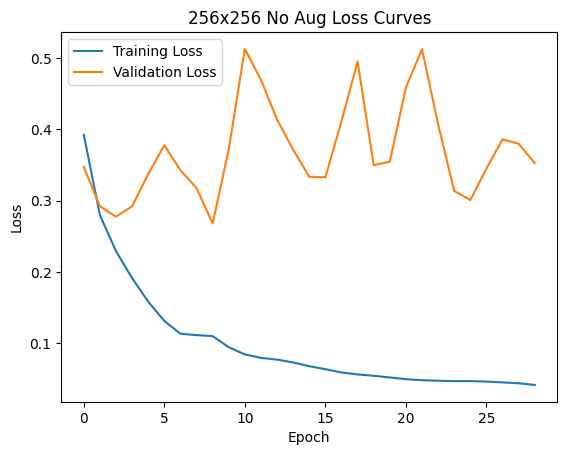

'\nuses model history to plot training and validation loss\n'

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.plot(history.history["dice_loss"], Label="Dice loss")

plt.plot(history.history["val_dice_loss"], Label="Validation dice loss")

plt.legend()
plt.title("256x256 No Aug Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig("192noAugLoss")
plt.show()

'''
uses model history to plot training and validation loss
'''

In [ ]:
val_images = []
val_masks = []
val_preds = []

for batch_images, batch_masks in val_dataset:
    preds = unet_model.predict(batch_images)
    val_images.append(batch_images.numpy())
    val_masks.append(batch_masks.numpy())
    val_preds.append(preds)

val_images = np.concatenate(val_images, axis=0)
val_masks = np.concatenate(val_masks, axis=0)
val_preds = np.concatenate(val_preds, axis=0)

val_preds_binary = (val_preds > 0.5).astype(np.float32)

jaccard = jaccard_index(val_masks, val_preds_binary).numpy()
dice = dice_score(val_masks, val_preds_binary).numpy()

print(f"Jaccard Index (IoU): {jaccard:.4f}")
print(f"Dice Score: {dice:.4f}")

'''
loop through the validation dataset and generate predicted mask
combine all batches and compute metrics on dataset
'''

1/1 [==============================] - 0s 63ms/step
Jaccard Index (IoU): 0.6555
Dice Score: 0.7919


'\nloop through the validation dataset and generate predicted mask\ncombine all batches and compute metrics on dataset\n'

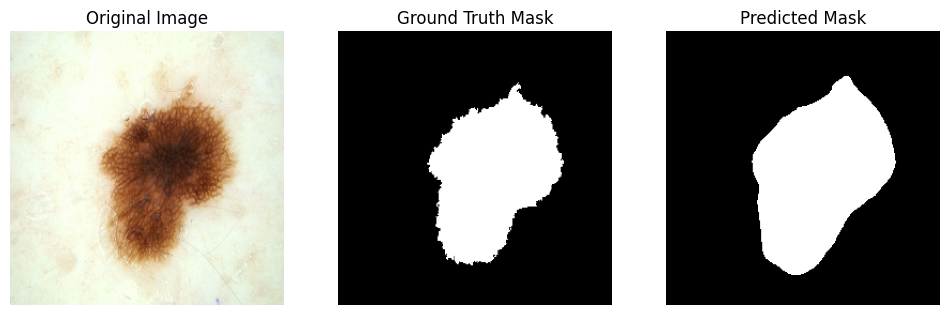

'\n\n'

In [ ]:
def show_sample(i):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(val_images[i])
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(val_masks[i]), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(val_preds_binary[i]), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    #plt.savefig("192noAugSample3.png")
    plt.show()

show_sample(33)

'''

'''

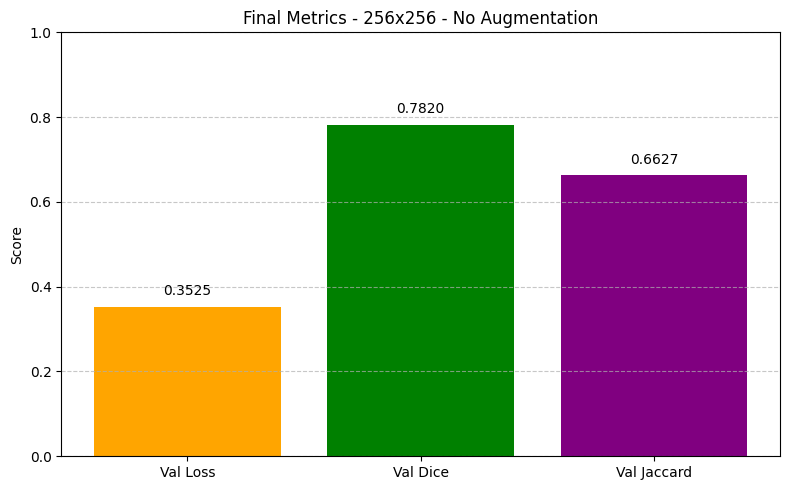

'\nPlot metrics for assessment\n'

In [ ]:
TITLE = "256x256 - No Augmentation"
SAVE_NAME = "summary_256_no_aug"

final_loss = history.history['val_loss'][-1]
final_dice = history.history['val_dice_score'][-1]
final_jaccard = history.history['val_jaccard_index'][-1]

metrics = ["Val Loss", "Val Dice", "Val Jaccard"]
values = [final_loss, final_dice, final_jaccard]

colors = ["orange", "green", "purple"]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=colors)
plt.title(f"Final Metrics - {TITLE}")
plt.ylabel("Score")

# Adjust y-limit based on max value (loss can be >1, others max at 1)
max_val = max(values)
if max_val <= 1:
    plt.ylim(0, 1.0)
else:
    plt.ylim(0, max_val + 0.1)

for bar, val in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f"{val:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.savefig(f"{SAVE_NAME}.png")
plt.show()


'''
Plot metrics for assessment
'''

In [ ]:
#unet_model.save("192noAug")

In [ ]:
'''model = load_model("unet_skin_lesion_model", custom_objects={
    "jaccard_index": jaccard_index,
    "dice_score": dice_score
})'''

'model = load_model("unet_skin_lesion_model", custom_objects={\n    "jaccard_index": jaccard_index,\n    "dice_score": dice_score\n})'